In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


In [3]:
df = pd.read_csv("webreg_data/results/enrollment_comparison_partial.csv")

required_courses = {
    'DSC_10', 'DSC_20', 'DSC_30', 'DSC_40A', 'DSC_40B',
    'DSC_80', 'DSC_100', 'DSC_102', 'DSC_106',
    'DSC_140A', 'DSC_140B', 'DSC_148',
    'DSC_180A', 'DSC_180B'
}

df['course_type'] = np.where(
    df['course'].isin(required_courses),
    'Required',
    'Elective'
)

df.head()

,course,quarter,quarter_label,enrolled,available,waitlisted,total,time,utilization_rate,waitlist_rate,available_rate,course_type
0,DSC_90,fa24,Fall 2024,7,13,0,20,2024-11-24T22:03:57,35.00,0.0,65.00,Elective
1,DSC_96,wi25,Winter 2025,32,8,0,40,2025-01-31T12:41:54,80.00,0.0,20.00,Elective
2,DSC_102,fa24,Fall 2024,71,33,0,104,2024-11-24T22:04:00,68.27,0.0,31.73,Required
3,DSC_102,sp25,Spring 2025,251,49,0,300,2025-05-15T03:50:58,83.67,0.0,16.33,Required
4,DSC_148,wi25,Winter 2025,110,15,0,125,2025-01-31T12:41:59,88.00,0.0,12.00,Required


In [5]:
def extract_course_num(course):
    match = re.search(r'(\d+)([A-Za-z]*)', course)
    if match:
        num = int(match.group(1))
        suffix = match.group(2)
        return (num, suffix)
    return (0, '')

df['course'] = pd.Categorical(
    df['course'],
    categories=sorted(df['course'].unique(), key=lambda x: extract_course_num(x)),
    ordered=True
)

quarter_order = ['Fall 2024', 'Winter 2025', 'Spring 2025']
df['quarter_label'] = pd.Categorical(
    df['quarter_label'], categories=quarter_order, ordered=True
)

df.head()

,course,quarter,quarter_label,enrolled,available,waitlisted,total,time,utilization_rate,waitlist_rate,available_rate,course_type
0,DSC_90,fa24,Fall 2024,7,13,0,20,2024-11-24T22:03:57,35.00,0.0,65.00,Elective
1,DSC_96,wi25,Winter 2025,32,8,0,40,2025-01-31T12:41:54,80.00,0.0,20.00,Elective
2,DSC_102,fa24,Fall 2024,71,33,0,104,2024-11-24T22:04:00,68.27,0.0,31.73,Required
3,DSC_102,sp25,Spring 2025,251,49,0,300,2025-05-15T03:50:58,83.67,0.0,16.33,Required
4,DSC_148,wi25,Winter 2025,110,15,0,125,2025-01-31T12:41:59,88.00,0.0,12.00,Required


In [6]:
colors = {
    'enrolled': '#2ecc71',
    'available': '#95a5a6',
    'waitlisted': '#e74c3c'
}

quarter_colors = {
    'Fall 2024': '#e67e22',
    'Winter 2025': '#9b59b6',
    'Spring 2025': '#3498db'
}

sns.set_style("whitegrid")


# Visualization 1 — Enrollment Distribution (Stacked)

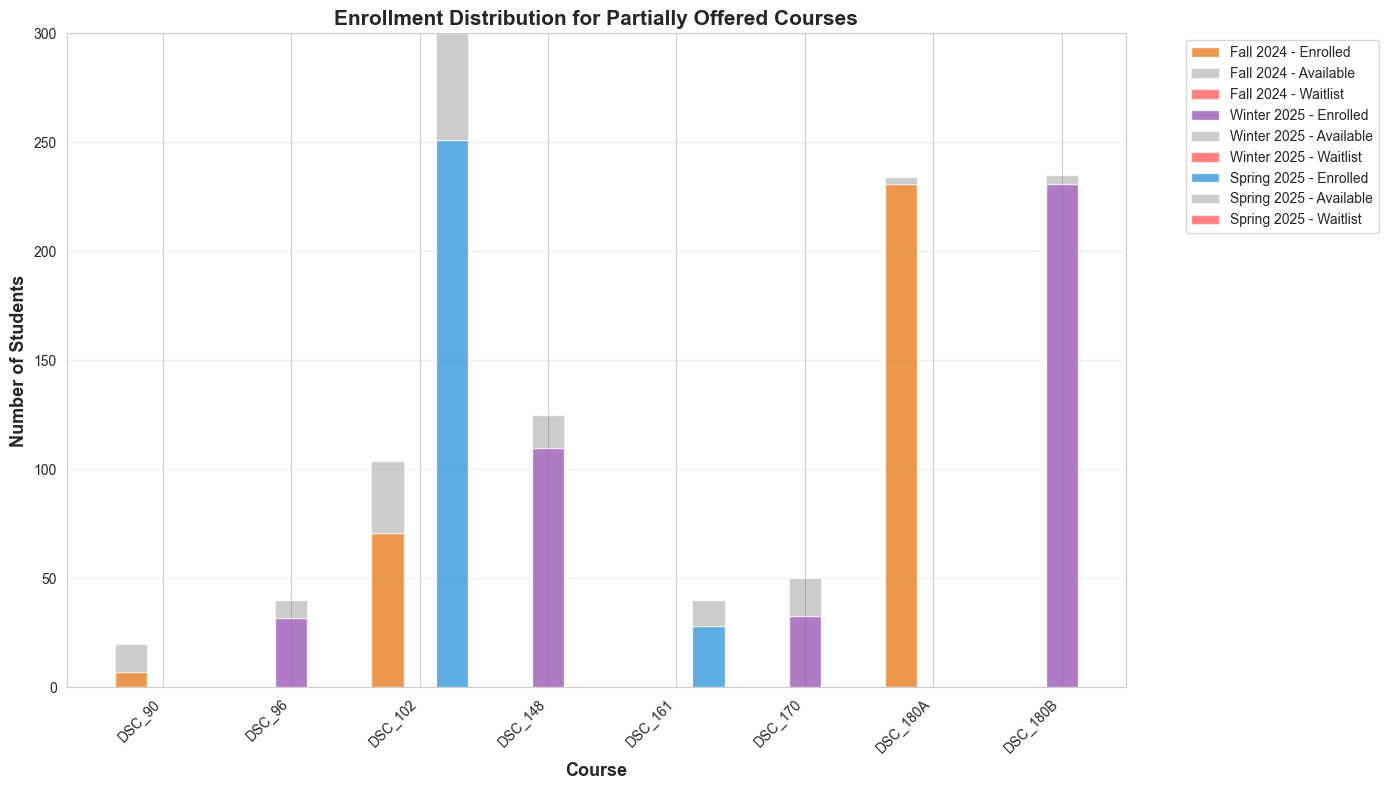

In [7]:
x_labels = sorted(df['course'].unique(), key=lambda x: extract_course_num(x))
x_positions = np.arange(len(x_labels))
width = 0.25

plt.figure(figsize=(14, 8))

for i, quarter in enumerate(quarter_order):
    qdata = df[df['quarter_label'] == quarter].sort_values('course')
    if qdata.empty:
        continue

    pos_map = [x_positions[x_labels.index(c)] for c in qdata['course']]
    enrolled = qdata['enrolled'].values
    available = qdata['available'].values
    waitlisted = qdata['waitlisted'].values

    plt.bar(np.array(pos_map) + (i - 1) * width, enrolled, width,
            color=quarter_colors[quarter], alpha=0.8, label=f'{quarter} - Enrolled')
    plt.bar(np.array(pos_map) + (i - 1) * width, available, width,
            bottom=enrolled, color='gray', alpha=0.4, label=f'{quarter} - Available')
    plt.bar(np.array(pos_map) + (i - 1) * width, waitlisted, width,
            bottom=enrolled + available, color='red', alpha=0.5, label=f'{quarter} - Waitlist')

plt.xlabel('Course', fontsize=13, fontweight='bold')
plt.ylabel('Number of Students', fontsize=13, fontweight='bold')
plt.title('Enrollment Distribution for Partially Offered Courses', fontsize=15, fontweight='bold')
plt.xticks(x_positions, x_labels, rotation=45, ha='right')

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Visualization 2 — Utilization Rate Comparison

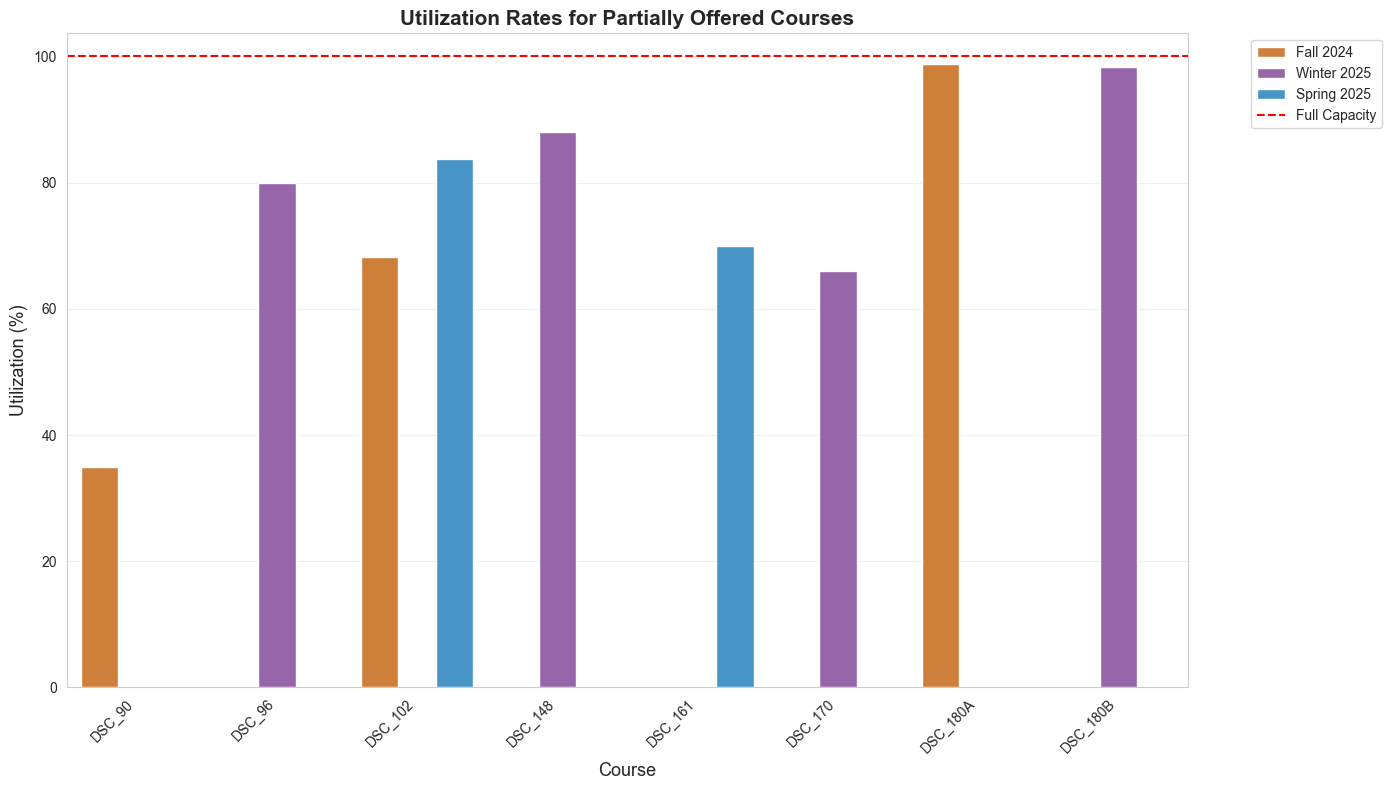

In [8]:
plt.figure(figsize=(14, 8))

sns.barplot(
    data=df,
    x='course',
    y='utilization_rate',
    hue='quarter_label',
    palette=quarter_colors
)

plt.axhline(100, color='red', linestyle='--', linewidth=1.5, label='Full Capacity')
plt.title('Utilization Rates for Partially Offered Courses', fontsize=15, fontweight='bold')
plt.ylabel('Utilization (%)', fontsize=13)
plt.xlabel('Course', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Visualization 3 — Faceted Enrollment Breakdown per Course

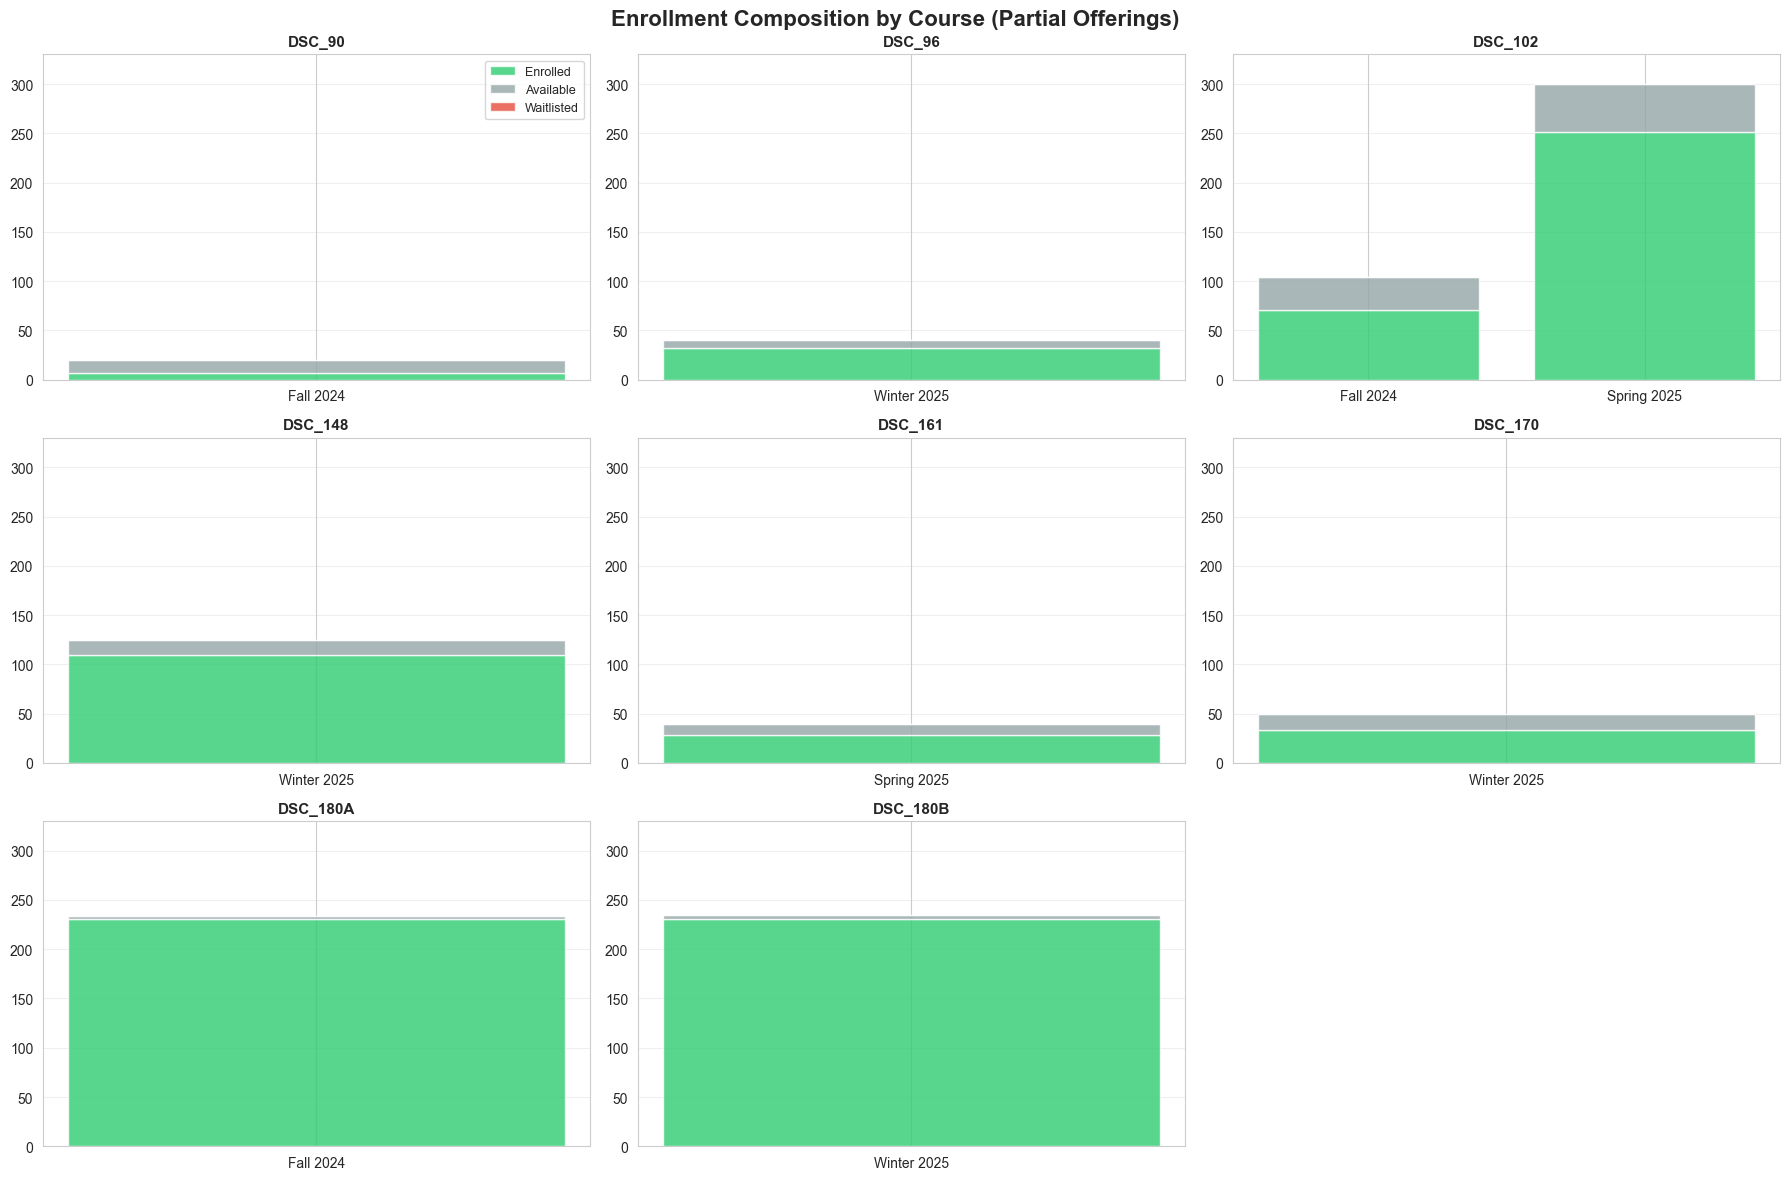

In [9]:
unique_courses = df['course'].unique()
n = len(unique_courses)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for idx, course in enumerate(unique_courses):
    cdata = df[df['course'] == course].sort_values('quarter_label')
    ax = axes[idx]

    ax.bar(cdata['quarter_label'], cdata['enrolled'],
           color=colors['enrolled'], alpha=0.8, label='Enrolled')
    ax.bar(cdata['quarter_label'], cdata['available'],
           bottom=cdata['enrolled'], color=colors['available'], alpha=0.8, label='Available')
    ax.bar(cdata['quarter_label'], cdata['waitlisted'],
           bottom=cdata['enrolled'] + cdata['available'],
           color=colors['waitlisted'], alpha=0.8, label='Waitlisted')

    ax.set_title(course, fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(df['total']) * 1.1)
    ax.grid(axis='y', alpha=0.3)

    if idx == 0:
        ax.legend(fontsize=9)

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle(
    'Enrollment Composition by Course (Partial Offerings)',
    fontsize=16,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


# Visualization 4 — Utilization Heatmap

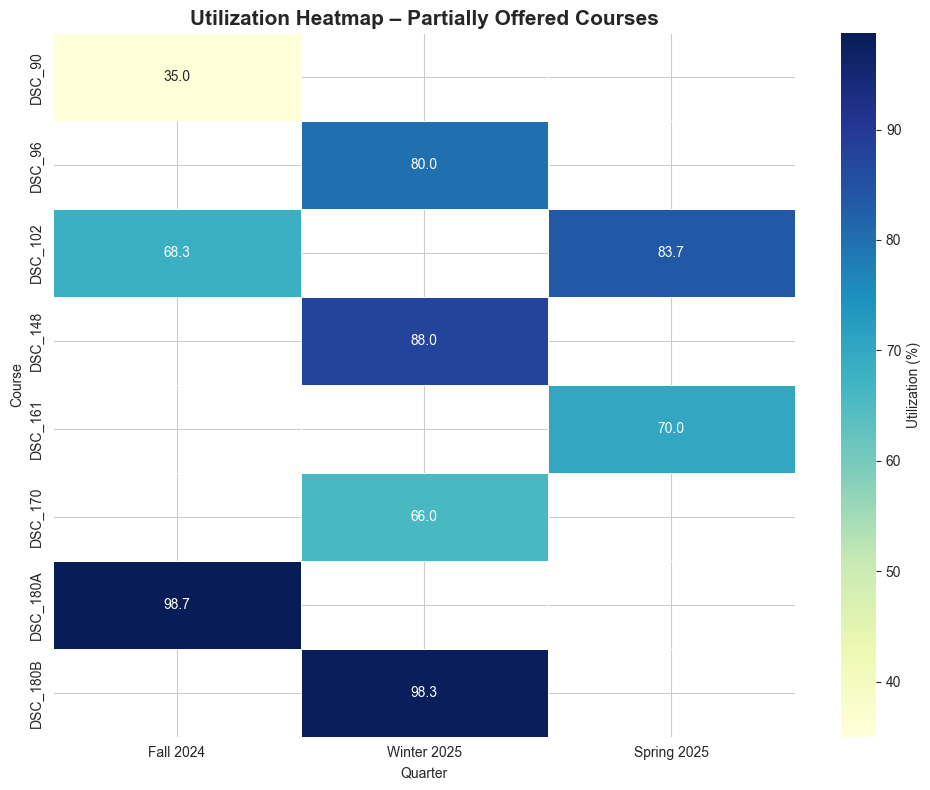

In [10]:
pivot = df.pivot(index='course', columns='quarter_label', values='utilization_rate')

plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'Utilization (%)'}
)

plt.title('Utilization Heatmap – Partially Offered Courses', fontsize=15, fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Course')
plt.tight_layout()
plt.show()


# Visualization 5 — Average Utilization Summary

/var/folders/r8/q05ww6td64s70f879mjv3v540000gn/T/ipykernel_49383/4132942834.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_util = df.groupby('quarter_label')['utilization_rate'].mean().reset_index()
/var/folders/r8/q05ww6td64s70f879mjv3v540000gn/T/ipykernel_49383/4132942834.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


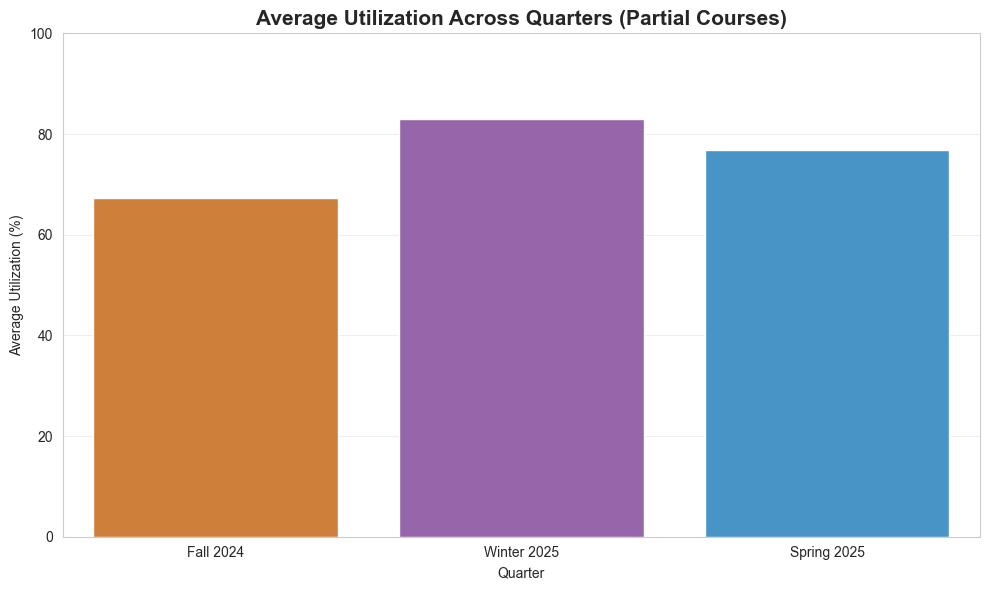

In [11]:
avg_util = df.groupby('quarter_label')['utilization_rate'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_util,
    x='quarter_label',
    y='utilization_rate',
    palette=quarter_colors
)

plt.title('Average Utilization Across Quarters (Partial Courses)', fontsize=15, fontweight='bold')
plt.ylabel('Average Utilization (%)')
plt.xlabel('Quarter')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Visualization 6 — Partial Courses Capacity Pressure

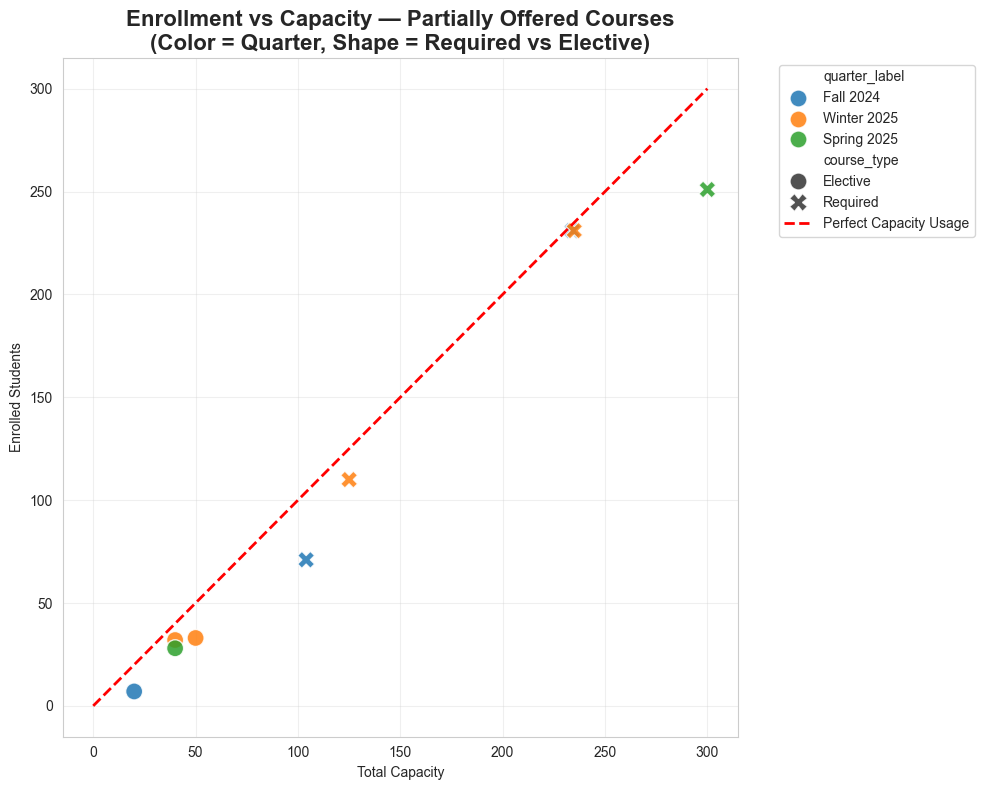

In [12]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df,
    x='total',
    y='enrolled',
    hue='quarter_label',        # Color → Quarter
    style='course_type',        # Shape → Required vs Elective
    s=150,
    alpha=0.85
)

max_cap = df['total'].max()
plt.plot(
    [0, max_cap],
    [0, max_cap],
    'r--',
    linewidth=2,
    label='Perfect Capacity Usage'
)

plt.title(
    'Enrollment vs Capacity — Partially Offered Courses\n'
    '(Color = Quarter, Shape = Required vs Elective)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Total Capacity')
plt.ylabel('Enrolled Students')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
